In [5]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from session_utils import *
from recalibration_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files = glob.glob('D:/T5_ClosedLoop/*')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### train linear regression on day 0, get baseline performance measure


In [52]:

# Get initial day performance and decoder:
day0       = DataStruct(files[2], alignScreens = True)
train_frac = 0.5
task       = None
sigma      = None
blocks     = None

train_x, test_x, train_y, test_y  = getTrainTest(day0, train_frac = train_frac, sigma = sigma, task = task, blocks = blocks, return_flattened = True)
ref_means                         = train_x.mean(axis = 0)
ref_scores, ref_decoder           = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])
 
print('Performance on day 0 with recalibration: R^2 = ', np.mean(ref_scores))

Performance on day 0 with recalibration: R^2 =  0.30009354140623473


In [55]:

# General parameters: 
train_frac = 0.5
task       = None


# HMM setup:
probThreshold = 0.4
gridSize      = 20  
stayProb      = 0.9999
vmKappa       = 2
probThreshold = 0.4

nStates       = gridSize**2
stateTrans    = np.eye(nStates)*stayProb #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs      = get_DiscreteTargetGrid(day0, gridSize = gridSize, task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + (1/nStates)


date          = [day0.date]
models        = list()
scores        = np.zeros((5, 12)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - HMM recalibration (initial); 4 - HMM recalibration (each session)
scores[:, 0]  = ref_scores[0]

hmm_new_ref = deepcopy(ref_decoder)
for i in range(3, 14):
    file        = files[i]
    new_dat     = DataStruct(file, alignScreens = True)
    date.append(new_dat.date)
    
    train_x, cursorPos, train_y, test_x, _, test_y = prep_HMMData(new_dat, train_frac = train_frac, task = task, return_flattened = True)
    
    scores[0, i-2] = ref_decoder.score(test_x - ref_means, test_y)                                           # no recalibration
    scores[1, i-2] = ref_decoder.score(test_x - train_x.mean(axis = 0), test_y)                              # mean recalibration
    scores[2, i-2] = LinearRegression(normalize = False).fit(train_x, train_y).score(test_x, test_y)         # full recalibration
    
    # Precision parameter for the von mises distribution
    hmm_init_ref     = train_HMMRecalibrate(deepcopy(ref_decoder), [train_x], [cursorPos], stateTrans, pStateStart, targLocs, vmKappa, probThreshold)
    hmm_new_ref      = train_HMMRecalibrate(hmm_new_ref, [train_x], [cursorPos], stateTrans, pStateStart, targLocs, vmKappa, probThreshold)
    scores[3, i-2]   = hmm_init_ref.score(test_x - train_x.mean(axis = 0), test_y)
    scores[4, i-2]   = hmm_new_ref.score(test_x - train_x.mean(axis = 0), test_y)
    
   
    print(new_dat.date, ' finished')

2016.10.05  finished
2016.10.07  finished
2016.10.10  finished
2016.10.12  finished
2016.10.13  finished
2016.10.17  finished
2016.10.19  finished
2016.10.24  finished
2016.10.26  finished
2016.10.31  finished
2016.12.06  finished


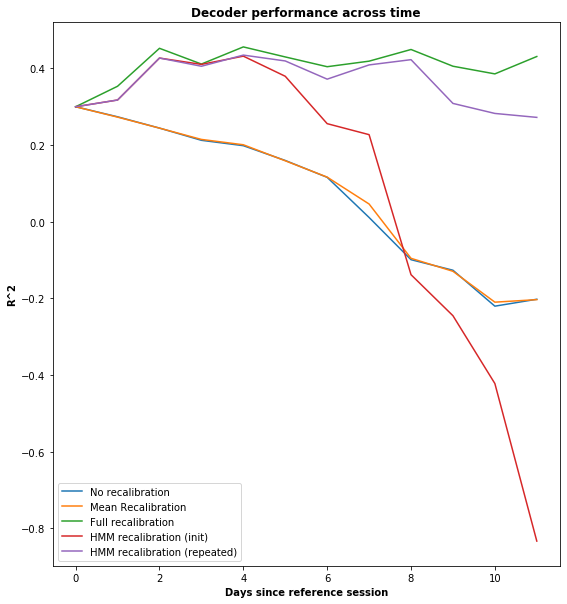

In [56]:
from preprocess import daysBetween
days = [daysBetween(day0.date, date[i]) for i in range(len(date))]


figSize(10, 20)

plt.subplot(1, 2, 1)
labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'HMM recalibration (init)', 'HMM recalibration (repeated)']
for i in range(5):
    plt.plot( scores[i, :].T, label = labels[i])

    
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
#plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

#plt.subplot(1, 2, 2)
#plt.plot(days, scores[2, :], label = 'Full recalibration')
#plt.plot(days, hmm_scores, label = 'HMM (consecutive updates)')
#plt.xlabel('Days')
#plt.ylabel('R^2')